In [1]:
import torch 
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
# 2d input (2, n)
inp = torch.randn(2,2)
input_shape = inp.shape
net = nn.Sequential(
    #nn.Conv2d(in_channels=1, out_channels=2, kernel_size=2, stride=2),
    nn.Linear(input_shape[1], 2),
    nn.Linear(2, 1),
)
# xavier initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    elif type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
net.apply(init_weights)
for layer in net:
    print(layer)

Linear(in_features=2, out_features=2, bias=True)
Linear(in_features=2, out_features=1, bias=True)


Layer 1 Weight matrix Parameter containing:
tensor([[ 1.1946, -0.7705],
        [-0.8686,  0.3581]], requires_grad=True)
Layer 2 Weight matrix Parameter containing:
tensor([[0.8391, 0.8755]], requires_grad=True)


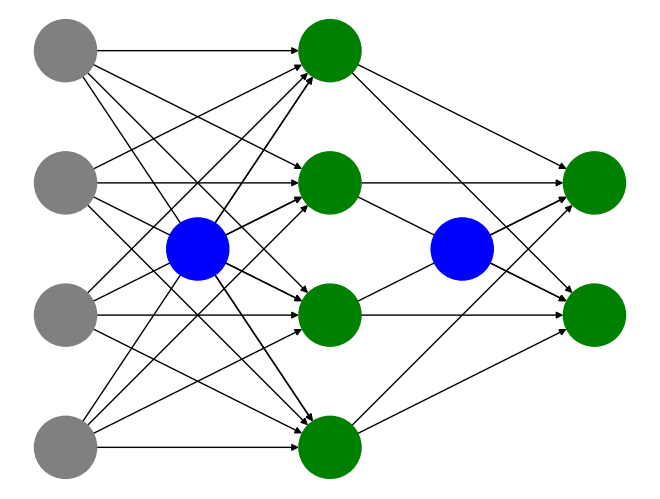

In [63]:
G = nx.DiGraph()

layer_type_map = {
    'input': 0,
    'linear': 1,
    'conv2d': 2,
    'bias': 3
}

inp_layer = torch.zeros_like(inp)
prev_layer = inp_layer
for i in range(prev_layer.shape[0]):
    for j in range(prev_layer.shape[1]):
        G.add_node(f'0_{i}_{j}')
        G.nodes[f'0_{i}_{j}']['subset_key'] = 0
        G.nodes[f'0_{i}_{j}']['type'] = layer_type_map['input']
        
subset_key=1
for i,layer in enumerate(net):
    layer_num =i+1
    if isinstance(layer, nn.Linear):
        weight_matrix = layer.weight
        print("Layer", layer_num, "Weight matrix", weight_matrix)
        # if bias
        bias_node = None
        if layer.bias is not None:
            bias_node = f'{layer_num}_b_{weight_matrix.shape[0]}'
            G.add_node(bias_node)
            G.nodes[bias_node]['subset_key'] = subset_key
            G.nodes[bias_node]['type'] = layer_type_map['bias']
        subset_key+=1
        for i in range(weight_matrix.shape[0]):
            for j in range(weight_matrix.shape[1]):
                G.add_node(f'{layer_num}_{i}_{j}')
                G.nodes[f'{layer_num}_{i}_{j}']['subset_key'] = subset_key
                G.nodes[f'{layer_num}_{i}_{j}']['type'] = layer_type_map['linear']
                if bias_node is not None:
                    weight = round(layer.bias[i].item(), 2)
                    G.add_edge(bias_node, f'{layer_num}_{i}_{j}', weight=weight)
                for k in range(prev_layer.shape[0]):
                    for l in range(prev_layer.shape[1]):
                        weight = round(weight_matrix[i][j].item(), 2)
                        G.add_edge(f'{layer_num-1}_{k}_{l}', f'{layer_num}_{i}_{j}', weight=weight)
        
        subset_key+=1

# Ensure all nodes have a 'subset_key' attribute
for node in G.nodes():
    if 'subset_key' not in G.nodes[node]:
        G.nodes[node]['subset_key'] = 0  # or any default value

# draw input nodes as gray, linear nodes as green, bias as blue
color_map = []
for node in G.nodes():
    if G.nodes[node]['type'] == layer_type_map['input']:
        color_map.append('gray')
    elif G.nodes[node]['type'] == layer_type_map['linear']:
        color_map.append('green')
    elif G.nodes[node]['type'] == layer_type_map['bias']:
        color_map.append('blue')
# use  multipartite_layout to position nodes based on their subset_key. show weights
pos = nx.multipartite_layout(G, subset_key='subset_key')
nx.draw(G, pos, with_labels=False, node_color=color_map, node_size=2000, font_size=10)
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()